# Quick Start — Tactile-GAT

In [12]:
# import yaml
# from data.pt_dataset import load_dataset
# import importlib.util, sys
# print('PyTorch', torch.__version__)

# cfg = yaml.safe_load(open('configs/tactile_gat_k5_s.yaml'))
# ds = load_dataset(cfg['data_root'], cfg.get('glob','*.pt'), cfg.get('field_map',{}), tip_num=cfg.get('tip_num'), k_last_frames=cfg.get('k_last_frames'))
# len(ds)

In [13]:
# # 跑 Tactile-GAT
# spec2 = importlib.util.spec_from_file_location("train_tactile", "scripts/train_tactile_gat.py")
# m2 = importlib.util.module_from_spec(spec2); sys.modules["train_tactile"] = m2; 
# spec2.loader.exec_module(m2)
# cfg2 = yaml.safe_load(open("configs/tactile_gat_k5_s.yaml", "r"))
# m2.main(cfg2)

# Tactile-GAT-5f-S — 一键训练 Notebook


In [14]:
import os, math, json, random
import numpy as np
import torch, torch.nn as nn
from torch.utils.data import random_split
from torch_geometric.loader import DataLoader
import yaml
from scripts.pytorchtools import EarlyStopping
from data.pt_dataset import load_dataset
from models.tactile_gat import TactileGAT

def set_seed(s=0):
    random.seed(s); np.random.seed(s); torch.manual_seed(s); torch.cuda.manual_seed_all(s)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cpu')

## 1) 读取配置


In [15]:
cfg = yaml.safe_load(open('configs/tactile_gat_k5_s.yaml','r'))
cfg


{'seed': 0,
 'data_root': 'data',
 'glob': '*.pt',
 'field_map': {},
 'tip_num': 331,
 'k_last_frames': 5,
 'val_ratio': 0.2,
 'batch_size': 8,
 'num_workers': 0,
 'in_dim': 3,
 'hidden_dim': 128,
 'num_layers': 4,
 'heads': 4,
 'edge_dim_s': 0,
 'time_emb_dim': 0,
 'dropout': 0.1,
 'readout': 'meanmax',
 'lr': 0.0003,
 'weight_decay': 0.0001,
 'optim': 'adam',
 'epochs': 200,
 'patience': 30,
 'label_indices': [0, 1],
 'loss_weights': [1.0, 1.0],
 'save_ckpt': True,
 'out_dir': './outputs/tactile_time0'}

## 2) 加载数据并自检


In [16]:
ds = load_dataset(
    cfg['data_root'],
    glob_pattern=cfg.get('glob','*.pt'),
    field_map=cfg.get('field_map',{}),
    tip_num=cfg.get('tip_num'),
    k_last_frames=cfg.get('k_last_frames'),
)
print('Total samples:', len(ds))
if len(ds) > 0:
    d0 = ds[0]
    print('x:', tuple(d0.x.shape))
    print('y:', tuple(d0.y.shape))
    print('t: min/max', int(d0.t.min()), int(d0.t.max()))
    print('Es:', getattr(d0,'edge_index_s', None).shape if hasattr(d0,'edge_index_s') else None)


Total samples: 144
x: (1655, 3)
y: (2,)
t: min/max 15 19
Es: torch.Size([2, 9300])


## 3) 切分/加载器


In [17]:
set_seed(cfg.get('seed',0))
n_total = len(ds)
n_val = int(n_total * cfg.get('val_ratio', 0.2))
n_train = n_total - n_val

train_set, val_set = random_split(
    ds, [n_train, n_val],
    generator=torch.Generator().manual_seed(cfg.get('seed',0))
)

train_loader = DataLoader(train_set, batch_size=cfg.get('batch_size',8), shuffle=True,  num_workers=cfg.get('num_workers',0))
val_loader   = DataLoader(val_set,   batch_size=cfg.get('batch_size',8), shuffle=False, num_workers=cfg.get('num_workers',0))

n_train, n_val


(116, 28)

## 4) 模型


In [18]:
model = TactileGAT(
    in_dim=cfg['in_dim'],
    hidden_dim=cfg.get('hidden_dim',128),
    num_layers=cfg.get('num_layers',4),
    heads=cfg.get('heads',4),
    edge_dim_s=cfg.get('edge_dim_s',0),
    time_emb_dim=cfg.get('time_emb_dim',32),  # 严格无时间信息对照可把这里改为 0
    dropout=cfg.get('dropout',0.1),
    readout=cfg.get('readout','meanmax'),
).to(device)

sum(p.numel() for p in model.parameters())


828290

## 5) 训练/评估函数


In [19]:
# def metrics_mae_rmse(y_true, y_pred):
#     with torch.no_grad():
#         err = (y_true - y_pred).abs()
#         return {
#             'MAE_Y':     err[:,0].mean().item(),
#             'MAE_theta': err[:,1].mean().item(),
#             'RMSE_Y':    torch.sqrt(((y_true[:,0]-y_pred[:,0])**2).mean()).item(),
#             'RMSE_theta':torch.sqrt(((y_true[:,1]-y_pred[:,1])**2).mean()).item(),
#         }

# def train_one_epoch(model, loader, opt, device, loss_weights=(1.0,1.0)):
#     model.train()
#     loss_fn = nn.SmoothL1Loss(reduction='none')
#     wY, wTh = loss_weights
#     tot = 0.0; n = 0
#     for data in loader:
#         data = data.to(device)
#         y = data.y
#         p = model(data)
#         lv = loss_fn(p, y)
#         loss = wY*lv[:,0].mean() + wTh*lv[:,1].mean()
#         opt.zero_grad(); loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
#         opt.step()
#         tot += loss.item() * y.size(0); n += y.size(0)
#     return tot / max(n,1)

# @torch.no_grad()
# def evaluate(model, loader, device):
#     model.eval()
#     ys, ps = [], []
#     for data in loader:
#         data = data.to(device)
#         ys.append(data.y)
#         ps.append(model(data))
#     y = torch.cat(ys,0); p = torch.cat(ps,0)
#     return metrics_mae_rmse(y,p)


def train_one_epoch(model, loader, opt, device, loss_weights=(1.0,1.0)):
    model.train()
    loss_fn = nn.SmoothL1Loss(reduction='none')
    wY, wTh = loss_weights
    tot = 0.0; n = 0
    for data in loader:
        data = data.to(device)
        p = model(data)                       # [B, 2]
        y = data.y
        if y.dim() == 1:                      # PyG 把 [2] 拼成 [B*2]
            y = y.view(p.size(0), -1)         # -> [B, 2]
        lv = loss_fn(p, y)
        loss = wY*lv[:,0].mean() + wTh*lv[:,1].mean()
        opt.zero_grad(); loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        opt.step()
        tot += loss.item() * y.size(0); n += y.size(0)
    return tot / max(n,1)

@torch.no_grad()
def evaluate(model, loader, device):
    model.eval(); ys=[]; ps=[]
    for data in loader:
        data = data.to(device)
        p = model(data)                       # [B, 2]
        y = data.y
        if y.dim() == 1:
            y = y.view(p.size(0), -1)         # -> [B, 2]
        ys.append(y); ps.append(p)
    y = torch.cat(ys,0); p = torch.cat(ps,0)
    return {
        "MAE_Y":     (y[:,0]-p[:,0]).abs().mean().item(),
        "MAE_theta": (y[:,1]-p[:,1]).abs().mean().item(),
        "RMSE_Y":    torch.sqrt(((y[:,0]-p[:,0])**2).mean()).item(),
        "RMSE_theta":torch.sqrt(((y[:,1]-p[:,1])**2).mean()).item(),
    }



In [20]:
# 用这版本
import math, json, os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# ---- 选择标签的工具：自动把 y 变成 [B,2]，并支持从多维 y 里挑列 ----
def _select_y(y, pred, cfg):
    """
    y:   Tensor from Data.y, shape [B*D] 或 [B, D] 或 [D]
    pred: 模型输出 [B, 2]
    cfg:  可以在 YAML 里加 label_indices: [iY, iTheta]
    """
    if y.dim() == 1:
        y = y.view(pred.size(0), -1)     # PyG 会把 [2] 拼成 [B*2]，这里还原成 [B,2]
    elif y.dim() == 2 and y.size(0) != pred.size(0):
        # 偶发对不齐（极少），按 batch 还原
        y = y.view(pred.size(0), -1)

    # 如果标签不是2维，按索引挑两列
    if y.size(-1) != 2:
        idx = cfg.get('label_indices', None)
        if idx is None:
            raise ValueError(
                f"y 有 {y.size(-1)} 维，请在 YAML 里设置 label_indices: [iY, iTheta] 指定两列。"
            )
        y = y[:, idx]
    return y

def metrics_mae_rmse(y_true, y_pred):
    with torch.no_grad():
        err = (y_true - y_pred).abs()
        return {
            'MAE_Y':      err[:,0].mean().item(),
            'MAE_theta':  err[:,1].mean().item(),
            'RMSE_Y':     torch.sqrt(((y_true[:,0]-y_pred[:,0])**2).mean()).item(),
            'RMSE_theta': torch.sqrt(((y_true[:,1]-y_pred[:,1])**2).mean()).item(),
        }

def train_one_epoch(model, loader, opt, device, cfg):
    model.train()
    # 和 baseline 对齐：L1Loss（也可改 SmoothL1Loss）
    use_l1 = True
    loss_fn = nn.L1Loss(reduction='none') if use_l1 else nn.SmoothL1Loss(reduction='none')
    wY, wTh = tuple(cfg.get('loss_weights', [1.0, 1.0]))
    epoch_loss, n = 0.0, 0

    for data in loader:
        data = data.to(device)
        pred = model(data)                    # [B,2]
        y = _select_y(data.y, pred, cfg)      # [B,2]

        lv = loss_fn(pred, y)                 # [B,2]
        loss = wY*lv[:,0].mean() + wTh*lv[:,1].mean()

        opt.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        opt.step()

        epoch_loss += loss.item() * y.size(0)
        n += y.size(0)

    return epoch_loss / max(n, 1)

@torch.no_grad()
def evaluate_loss(model, loader, device, cfg):
    model.eval()
    use_l1 = True
    loss_fn = nn.L1Loss(reduction='none') if use_l1 else nn.SmoothL1Loss(reduction='none')
    wY, wTh = tuple(cfg.get('loss_weights', [1.0, 1.0]))
    tot, n = 0.0, 0
    for data in loader:
        data = data.to(device)
        pred = model(data)
        y = _select_y(data.y, pred, cfg)
        lv = loss_fn(pred, y)
        loss = wY*lv[:,0].mean() + wTh*lv[:,1].mean()
        tot += loss.item() * y.size(0)
        n += y.size(0)
    return tot / max(n, 1)

@torch.no_grad()
def evaluate_mae(model, loader, device, cfg):
    model.eval()
    ys, ps = [], []
    for data in loader:
        data = data.to(device)
        pred = model(data)
        y = _select_y(data.y, pred, cfg)
        ys.append(y); ps.append(pred)
    if not ys:
        return {'MAE_Y': float('nan'), 'MAE_theta': float('nan')}
    y = torch.cat(ys, 0); p = torch.cat(ps, 0)
    m = metrics_mae_rmse(y, p)
    return {'MAE_Y': m['MAE_Y'], 'MAE_theta': m['MAE_theta']}


def plot_history(history, best_epoch=None, stop_epoch=None, save_to=None):
    """
    best_epoch: 验证集最优(最小 val loss)的 epoch（从 1 开始计）
    stop_epoch: 触发 early stopping 的 epoch（从 1 开始计）
    """
    plt.figure(figsize=(7,5))
    plt.plot(history["train_loss"], label="train")
    plt.plot(history["val_loss"],   label="val")

    if best_epoch is not None:
        plt.axvline(best_epoch, color="tab:red", linestyle="--", label=f"best (epoch {best_epoch})")
    if stop_epoch is not None:
        plt.axvline(stop_epoch, color="tab:green", linestyle=":", label=f"early stop (epoch {stop_epoch})")

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    if save_to:
        plt.savefig(save_to, bbox_inches='tight')
    plt.show()


## 6) 开始训练


In [21]:
from torch_geometric.nn import global_add_pool, global_max_pool

data = next(iter(train_loader)).to(device)

# 逐图取“最后一帧”的掩码
t_float = data.t.to(torch.float32).unsqueeze(-1)     # [N,1]
tmax_per_g = global_max_pool(t_float, data.batch).squeeze(-1)  # [G]
m = (t_float.squeeze(-1) == tmax_per_g[data.batch])  # [N] True=最后一帧

picked_per_graph = global_add_pool(m.float().unsqueeze(-1), data.batch).squeeze(-1)
print('picked per graph (expect all 331):', picked_per_graph.cpu().numpy())


picked per graph (expect all 331): [331. 331. 331. 331. 331. 331. 331. 331.]


Validation loss decreased (inf --> 7.751653).  Saving model ...
Ep001 | train=9.4220 | val=7.7517 | lr=3.00e-04
Validation loss decreased (7.751653 --> 7.730873).  Saving model ...
Ep002 | train=9.1537 | val=7.7309 | lr=3.00e-04
Validation loss decreased (7.730873 --> 7.698512).  Saving model ...
Ep003 | train=9.0103 | val=7.6985 | lr=3.00e-04
Validation loss decreased (7.698512 --> 7.639816).  Saving model ...
Ep004 | train=9.0467 | val=7.6398 | lr=3.00e-04
EarlyStopping counter: 1 out of 30

Ep005 | train=9.0345 | val=7.7003 | lr=3.00e-04
EarlyStopping counter: 2 out of 30

Ep006 | train=8.9814 | val=7.8504 | lr=3.00e-04
EarlyStopping counter: 3 out of 30

Ep007 | train=8.9539 | val=7.8070 | lr=3.00e-04
Epoch 00008: reducing learning rate of group 0 to 1.5000e-04.
EarlyStopping counter: 4 out of 30

Ep008 | train=8.9405 | val=7.8698 | lr=1.50e-04
EarlyStopping counter: 5 out of 30

Ep009 | train=9.0286 | val=7.8958 | lr=1.50e-04
EarlyStopping counter: 6 out of 30

Ep010 | train=8.906

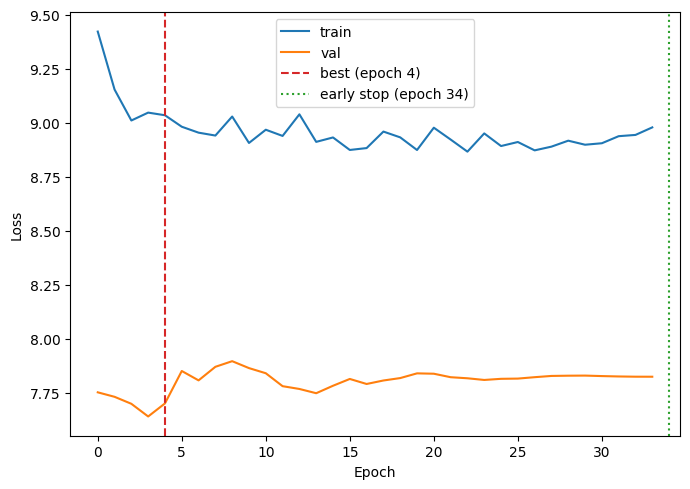

In [22]:
# b = next(iter(train_loader))
# print('y raw shape:', b.y.shape)
# # 若你在 YAML 里用了 label_indices，从 batch 里拿到 pred 后会被 _select_y 按列挑成 [B,2]


# === 开始训练（baseline 一致：按 val_loss 早停 + ReduceLROnPlateau） ===
out_dir = cfg.get('out_dir', './outputs')
os.makedirs(out_dir, exist_ok=True)

# 优化器与 baseline 对齐（如需 AdamW 可改 cfg['optim']='adamw'）
Opt = torch.optim.Adam if cfg.get('optim','adam').lower()=='adam' else torch.optim.AdamW
wd  = cfg.get('weight_decay', 0.0 if cfg.get('optim','adam').lower()=='adam' else 1e-4)
opt = Opt(model.parameters(), lr=cfg.get('lr', 1.5e-3), weight_decay=wd)

# 学习率调度（监控 val_loss）
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(
    opt, mode='min', factor=0.5, patience=3, threshold=1e-3, verbose=True
)

# 老师的 EarlyStopping（只保存 state_dict）
patience  = int(cfg.get("patience", 30))
es_delta  = float(cfg.get("es_delta", 0.0))   # 可在 YAML 里设阈值，默认 0
ckpt_name = "seqgat_best.pth" if model.__class__.__name__.lower().startswith("seqgat") else "tactile_gat_best.pth"
ckpt_path = os.path.join(out_dir, ckpt_name)
early_stopping = EarlyStopping(patience=patience, verbose=True, delta=es_delta, path=ckpt_path)

history = {"train_loss": [], "val_loss": []}
best_val = float('inf')
best_epoch = None
stop_epoch = None

epochs = int(cfg.get('epochs', 200))
for epoch in range(1, epochs+1):
    tr = train_one_epoch(model, train_loader, opt, device, cfg)   # 训练损失（L1）
    vl = evaluate_loss(model, val_loader, device, cfg)            # 验证损失

    history["train_loss"].append(tr)
    history["val_loss"].append(vl)

    # LR 调度监控 val_loss
    sched.step(vl)

    # 记录最佳（用于画图标注）
    if vl < best_val - 1e-12:
        best_val = vl
        best_epoch = epoch

    # 老师的早停：传 val_loss 与 model
    early_stopping(vl, model)
    print(f"Ep{epoch:03d} | train={tr:.4f} | val={vl:.4f} | lr={opt.param_groups[0]['lr']:.2e}")
    if early_stopping.early_stop:
        stop_epoch = epoch
        print(f"Early stopping at epoch {epoch} (patience={patience}, monitor=val_loss)")
        break

# —— 加载最佳权重（state_dict），计算 Train/Val MAE（仅汇报，不参与早停）——
state = torch.load(ckpt_path, map_location=device)   # 注意：老师的文件只存 state_dict
model.load_state_dict(state)

mae_tr = evaluate_mae(model, train_loader, device, cfg)
mae_va = evaluate_mae(model, val_loader, device, cfg)

print(f"\n[MAE] Train: Y={mae_tr['MAE_Y']:.4f} | θ={mae_tr['MAE_theta']:.4f}")
print(f"[MAE] Valid: Y={mae_va['MAE_Y']:.4f} | θ={mae_va['MAE_theta']:.4f}")

# —— 保存并画 loss 曲线（标注 best/early-stop）——
with open(os.path.join(out_dir, "loss_history.json"), "w") as f:
    json.dump(history, f, indent=2)

plot_history(
    history,
    best_epoch=best_epoch,        # val loss 最低的 epoch（1-based）
    stop_epoch=stop_epoch,        # 触发早停的 epoch（1-based）
    save_to=os.path.join(out_dir, "loss_plot.png"),
)
